In [77]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/modos/"
rehome = "/home/german/labo/18/egfr/gram/"
aa = 277

277

In [10]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [11]:
function qgrammian0(mtx_1, mtx_2, weight_1 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
      
    if weight_1 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        weighted = diag(mtx_g) .* weight_1
        zeta = sum(weighted)
    else
        zeta = mean(diag(mtx_g))   
    end
    
    
    return zeta
end

qgrammian0 (generic function with 2 methods)

In [12]:
# Leo nombres de structuras
tmp = readdlm(string(rehome, "/pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(string(rehome, "/am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(string(rehome, "/im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

In [13]:
# Leo nonmissing residuos de pocket
tmp = readdlm(string(rehome, "nonmis_aa_pocket"))
nonmis_aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(nonmis_aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

nonmis_aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    nonmis_aa_pocket_3[3*i - 2] = nonmis_aa_pocket[i] * 3
    nonmis_aa_pocket_3[3*i - 1] = nonmis_aa_pocket[i] * 3 + 1
    nonmis_aa_pocket_3[3*i] = nonmis_aa_pocket[i] * 3 + 2
end

# Leo todos los residuos de pocket
tmp = readdlm(string(rehome, "aa_pocket"))
aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    aa_pocket_3[3*i - 2] = aa_pocket[i] * 3
    aa_pocket_3[3*i - 1] = aa_pocket[i] * 3 + 1
    aa_pocket_3[3*i] = aa_pocket[i] * 3 + 2
end

## Versión con los residuos nonmissing del pocket

In [90]:
am_pesos = Array{Float64, 2}(aa_36, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]

    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]

    am_pesos[:, i] = [ sum(modos[nonmis_aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    am_pesos[:, i] = am_pesos[:, i] ./ sum(am_pesos[:, i]);
end

In [91]:
im_pesos = Array{Float64, 2}(aa_36, length(im_list))

for i = 1:length(im_list)
    each = im_list[i]
    
    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
    
    im_pesos[:, i] = [ sum(modos[nonmis_aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    im_pesos[:, i] = im_pesos[:, i] ./ sum(im_pesos[:, i]);
end

## Versión con todos los residuos del pocket

In [45]:
am_pesos = Array{Float64, 2}(aa_36, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]

    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]

    am_pesos[:, i] = [ sum(modos[aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    am_pesos[:, i] = am_pesos[:, i] ./ sum(am_pesos[:, i]);
end

In [44]:
im_pesos = Array{Float64, 2}(aa_36, length(im_list))

for i = 1:length(im_list)
    each = im_list[i]
    
    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
    
    im_pesos[:, i] = [ sum(modos[aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    im_pesos[:, i] = im_pesos[:, i] ./ sum(im_pesos[:, i]);
end

## Obtengo los zeta vals

In [46]:
am_zeta = zeros(length(am_list) - 1, length(am_list) - 1)

for i = 1:length(am_list)
    each = am_list[i]
    for j = i+1:length(am_list)
        cada = am_list[j]

        modos_1 = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
        modos_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_ord"))[:, 1:aa_36]

        am_zeta[j-1, i] = qgrammian0(modos_1, modos_2, am_pesos[:, j])
    end
end

In [47]:
im_zeta = zeros(length(im_list) - 1, length(im_list) - 1)

for i = 1:length(im_list)
    each = im_list[i]
    for j = i+1:length(im_list)
        cada = im_list[j]

        modos_1 = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
        modos_2 = readdlm(string(rehome, each, "/", each, "_", cada, "_ord"))[:, 1:aa_36]

        im_zeta[j-1, i] = qgrammian0(modos_1, modos_2, im_pesos[:, j])
    end
end

# Grafico

In [92]:
vec_im_pesos = mapslices(x -> mean(x), im_pesos, 2)
vec_im_pesos = reshape(vec_im_pesos, length(vec_im_pesos))
vec_am_pesos = mapslices(x -> mean(x), am_pesos, 2)
vec_am_pesos = reshape(vec_am_pesos, length(vec_am_pesos))

df_pesos = DataFrame(Weights = [ vec_im_pesos ./ vec_im_pesos[1] ; vec_am_pesos ./ vec_am_pesos[1]], 
    Modes = [ collect(1:aa_36) ; collect(1:aa_36) ],
    Conformer = repeat(["IM" ; "AM"], inner = [ aa_36]));

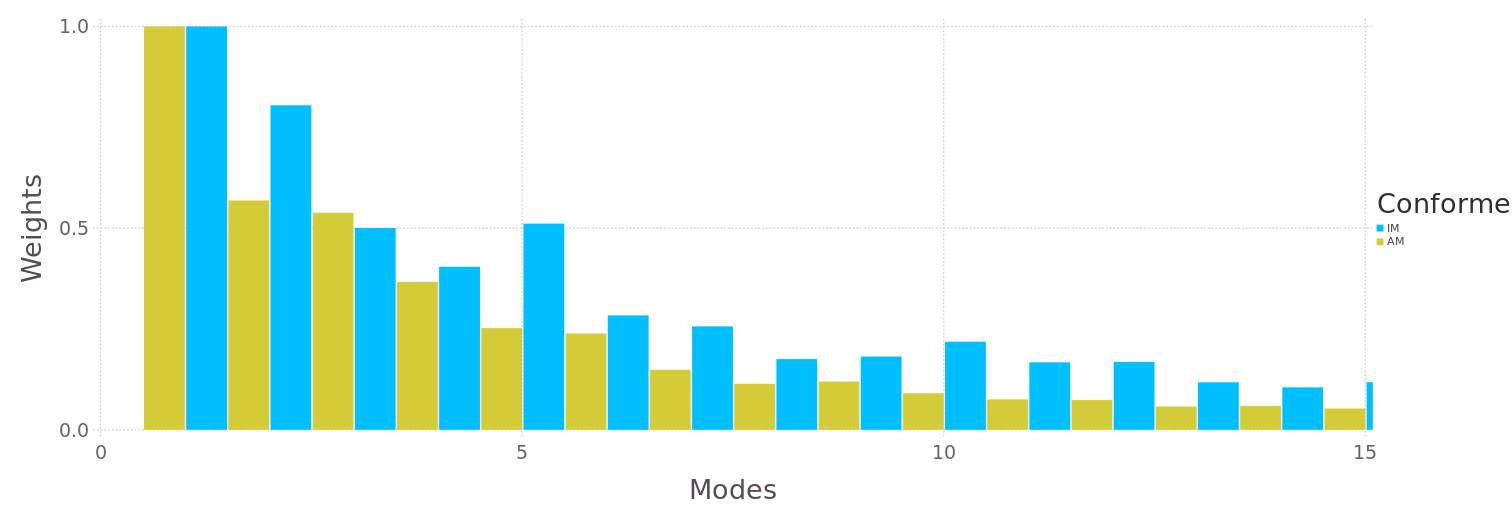

In [93]:
pdf_pesos = plot(df_pesos, x="Modes", y="Weights", color = "Conformer", Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Coord.cartesian(xmin = 0, xmax = 15),

    Theme(bar_spacing = 2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

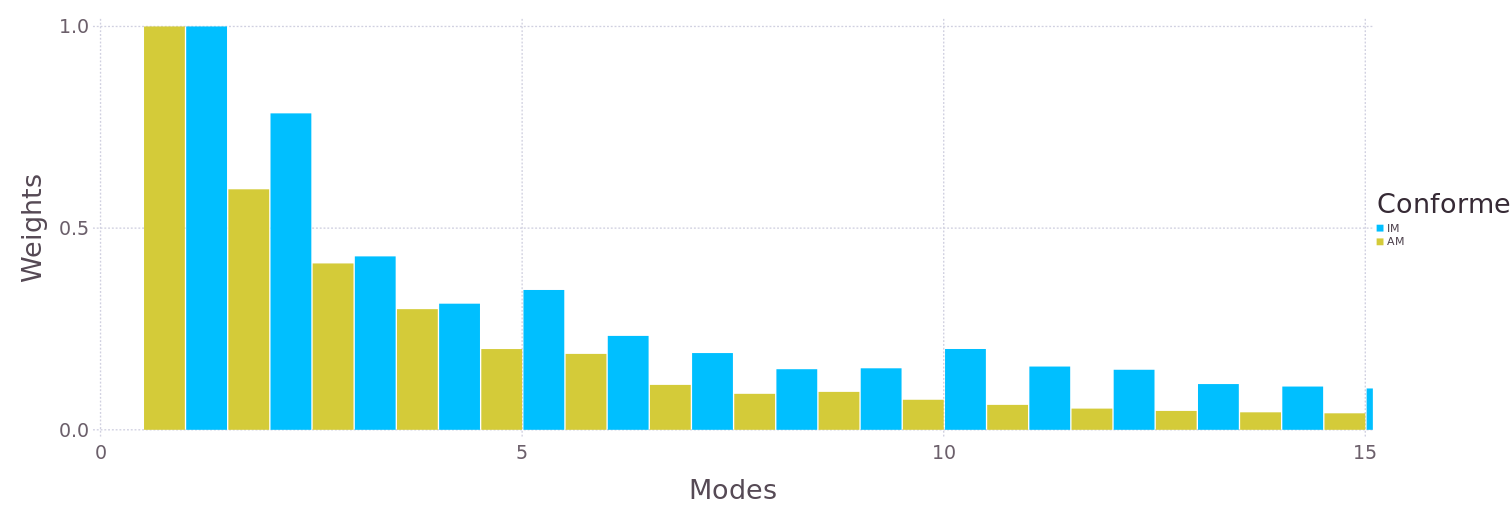

In [85]:
pdf_pesos = plot(df_pesos, x="Modes", y="Weights", color = "Conformer", Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Coord.cartesian(xmin = 0, xmax = 15),

    Theme(bar_spacing = 2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [50]:
am_zeta

31×31 Array{Float64,2}:
 0.999985  0.0       0.0       0.0       …  0.0       0.0       0.0     
 0.999977  0.999964  0.0       0.0          0.0       0.0       0.0     
 0.99998   0.999953  0.999976  0.0          0.0       0.0       0.0     
 0.99996   0.999962  0.99991   0.999946     0.0       0.0       0.0     
 0.999836  0.999847  0.999838  0.999854     0.0       0.0       0.0     
 0.999978  0.999987  0.99994   0.999952  …  0.0       0.0       0.0     
 0.999749  0.999721  0.999726  0.99975      0.0       0.0       0.0     
 0.999989  0.999974  0.999977  0.999982     0.0       0.0       0.0     
 0.999725  0.999735  0.999667  0.999735     0.0       0.0       0.0     
 0.999382  0.99944   0.999326  0.999319     0.0       0.0       0.0     
 0.999953  0.999951  0.999905  0.999924  …  0.0       0.0       0.0     
 0.999983  0.999965  0.99998   0.999973     0.0       0.0       0.0     
 0.999962  0.999933  0.999983  0.999975     0.0       0.0       0.0     
 ⋮                         

In [56]:
im_zeta

14×14 Array{Float64,2}:
 0.999773  0.0       0.0       0.0       …  0.0       0.0       0.0     
 0.987472  0.99982   0.0       0.0          0.0       0.0       0.0     
 0.999965  0.999831  0.999925  0.0          0.0       0.0       0.0     
 0.998553  0.998068  0.998525  0.998587     0.0       0.0       0.0     
 0.999676  0.999808  0.999442  0.99962      0.0       0.0       0.0     
 0.998455  0.998644  0.998046  0.998062  …  0.0       0.0       0.0     
 0.999439  0.999569  0.999169  0.99934      0.0       0.0       0.0     
 0.999032  0.998251  0.998668  0.999124     0.0       0.0       0.0     
 0.97212   0.999574  0.999347  0.999653     0.0       0.0       0.0     
 0.999832  0.999907  0.999718  0.999813     0.0       0.0       0.0     
 0.999859  0.999899  0.999805  0.999847  …  0.0       0.0       0.0     
 0.997949  0.99891   0.997393  0.997021     0.996783  0.0       0.0     
 0.998868  0.999358  0.998568  0.99813      0.998662  0.999725  0.0     
 0.999469  0.999367  0.9992

In [54]:
reshape(im_zeta, length(im_zeta))[5:16]

12-element Array{Float64,1}:
 0.999676
 0.998455
 0.999439
 0.999032
 0.97212 
 0.999832
 0.999859
 0.997949
 0.998868
 0.999469
 0.0     
 0.99982 

In [ ]:
pdf_mode_κ_whole_Whis = plot(df_mode_κ_whole_Whis, x="Collectivity", y="Probability", Geom.bar,
Guide.title("Figure 2.AA"),
Guide.ylabel("δV * Probability", orientation=:vertical), Coord.cartesian(xmin = 0, xmax = 0.7),
Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue "),
minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [21]:
writedlm(string(rehome, "am_zeta"), am_zeta)

In [22]:
writedlm(string(rehome, "im_zeta"), im_zeta)